## This notebook does the following:
- reads pedestrian tracks form a pickle object
- chooses track pairs which co-existed in a video for more than 300 frames
- smoothes the tracks to get rid of noise introduced by localization error in detection algorithm
- Minmax normalize the tracks within a specified range
- Visualizes the track pairs as particles in 2d space to understand their interaction

In [272]:
import numpy as np
import time
import Person
import random
from matplotlib.widgets import RectangleSelector
import matplotlib.patches as patches
import cv2
import os
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
%matplotlib inline 

import imageio
from IPython.display import HTML

In [301]:
class Person:
    tracks = []
    def __init__(self, i, tl, br, f):
        self.id = i
        self.tl = tl
        self.br = br
        self.frameId = f
        
        self.tracks = []
        self.frames = []
        self.framesDet = []
        
        self.tracks.append((tl,br))
        self.frames.append(f)
        self.framesDet.append(True)

        self.frameLost = 0
        self.area = abs((self.br[0]-self.tl[0]) * (self.br[1]-self.tl[1]))
        
        self.active = True

    def getTracks(self):
        return self.tracks
    def getId(self):
        return self.id
    def getFrameLost(self):
        return self.frameLost
    def getTl(self):
        return self.tl
    def getBr(self):
        return self.br
    def isActive(self):
        return self.active
    def getMid(self):
        return ((self.tl[0]+ self.br[0])/2 , (self.tl[1]+ self.br[1])/2)
    def getArea(self):
        return self.area       
    def deactivate(self):
        self.active = False

    def getPredictedOffset(self):#how are you predicting?
        l = len(self.tracks)
        if l <= 1:
            return (0,0)
        if l >= 3:
            b=l-3
        else:
            b= l-2
        b=0
        p2 = cal_mid(self.tracks[l-1][0],self.tracks[l-1][1])
        p1 = cal_mid(self.tracks[b][0],self.tracks[b][1])
        
        deltaX = (p2[0]-p1[0])/(l-b)
        deltaY = (p2[1]-p1[1])/(l-b)
        return (deltaX, deltaY)#changed
    
    def walk(self):
        deltaX,deltaY = self.getPredictedOffset()
        self.tl = (self.tl[0] + deltaX, self.tl[1] + deltaY)
        self.br = (self.br[0] + deltaX, self.br[1] + deltaY)
        self.frameId += 1
        self.tracks.append((self.tl,self.br))
        self.frames.append(self.frameId)
        self.framesDet.append(False)
        self.frameLost = self.frameLost+1
        
        if self.frameLost > 10:
            self.deactivate()
        
    def matched(self, tl, br):       
        self.tl = tl
        self.br = br
        self.tracks[len(self.tracks)-1] = (tl,br)
        self.framesDet[len(self.framesDet)-1] = True
        self.frameLost = 0


In [194]:
def cal_distance(p1,p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

def shift_point(point,shift):
    return ( point[0] + shift[0], point[1] + shift[1] )

def cal_mid(p1,p2):
    return ((p1[0]+ p2[0])/2 , (p1[1]+ p2[1])/2)

In [195]:
def plotTrack(person, h,w):
    tracks = person.getTracks()
    track_mids = [cal_mid(p1,p2) for p1,p2 in tracks]
    track_x = [x for x,y in track_mids]
    track_y = [y for x,y in track_mids]
    plt.figure()
    plt.xlim((0,640))
    plt.ylim((0,352))
    plt.plot(track_x,track_y)
    plt.title(p.getId())

In [196]:
def plotPair(tracks1,tracks2,h,w):
    #tracks1 = person1.getTracks()
    #track_mids1 = [cal_mid(p1,p2) for p1,p2 in tracks1]
    track1_x = [x for x,y in tracks1]
    track1_y = [y for x,y in tracks1]
    #tracks2 = person2.getTracks()
    #track_mids2 = [cal_mid(p1,p2) for p1,p2 in tracks2]
    track2_x = [x for x,y in tracks2]
    track2_y = [y for x,y in tracks2]
    
    plt.figure()
    #plt.xlim((0,640))
    #plt.ylim((0,352))
    plt.plot(track1_x,track1_y,linewidth=2.0)
    plt.plot(track2_x,track2_y,linewidth=2.0)
    #plt.title(str(person1.getId()),"--",str(person2.getId()))

In [197]:
def imputeTracks(p,h,w):
    for i in range(500):
        if(p.tl[0] > 0 and p.tl[0] < w and p.tl[1] >0 and p.tl[1] <h):
            if(p.br[0] > 0 and p.br[0] < w and p.br[1] >0 and p.br[1] <h):
                p.walk()

In [198]:
def overlap(p1,p2,t):
    f1 = set(p1.frames)
    f2 = set(p2.frames)
    return (len(f1.intersection(f2)) > t, list(f1.intersection(f2)) )

In [199]:
def smoothTrack(tracks):
    x = [x for x,y in tracks]
    y = [y for x,y in tracks]
    x = savgol_filter(x, 101, 1)
    y = savgol_filter(y, 101, 1)
    return list(zip(x,y))

In [245]:
def minMaxTracks(tracks, minx, miny, maxx, maxy):
    x = np.array([x for x,y in tracks])
    y = np.array([y for x,y in tracks])
    X_std = (x - minx) / (maxx - minx)
    x = list(X_std * 200) 
    Y_std = (y - miny) / (maxy - miny)
    y = list(Y_std * 100) 
    return list(zip(x,y))

In [265]:
def minMaxPairs(pair):
    t1 = pair[0]
    t2 = pair[1]
    x1 = np.array([x for x,y in t1])
    x2 = np.array([x for x,y in t2])
    minx = min(x1.min(),x2.min())
    maxx =  max(x1.max(),x2.max())
    y1 = np.array([y for x,y in t1])
    y2 = np.array([y for x,y in t2])
    miny = min(y1.min(),y2.min())
    maxy =  max(y1.max(),y2.max())
    return (minMaxTracks(t1,minx, miny, maxx, maxy),minMaxTracks(t2,minx, miny, maxx, maxy))

In [318]:
height,width = (352, 640)

In [341]:
with open('street_7.pkl', 'rb') as input:
    persons = pickle.load(input)

In [345]:
pairs = []
for i in range(len(persons)):
    for j in range(i+1,len(persons)):
        ov = overlap(persons[i],persons[j],300)
        if ov[0]:
            t1 = [t for t,f in zip(persons[i].tracks,persons[i].frames) if f in ov[1]]
            t2 = [t for t,f in zip(persons[j].tracks,persons[j].frames) if f in ov[1]]
            track_mids1 = [cal_mid(p1,p2) for p1,p2 in t1]
            track_mids2 = [cal_mid(p1,p2) for p1,p2 in t2]
            pairs.append((track_mids1,track_mids2))
len(pairs)

360

In [346]:
# smooth pairs
pairs = [(smoothTrack(t1),smoothTrack(t2)) for t1,t2 in pairs]

In [347]:
# smooth pairs
pairs = [minMaxPairs((t1,t2)) for t1,t2 in pairs]

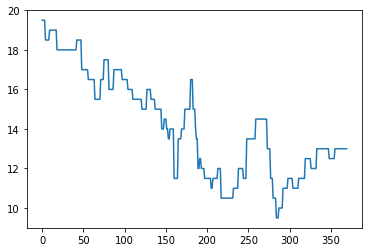

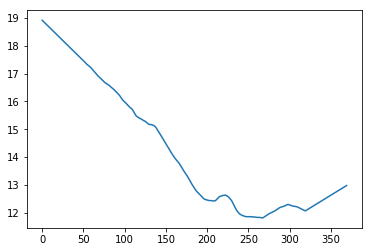

In [167]:
t = [y for x,y in pairs[3][0]]
plt.figure()
plt.plot(t)
plt.figure()
t = savgol_filter(t, 101, 1)
plt.plot(t)

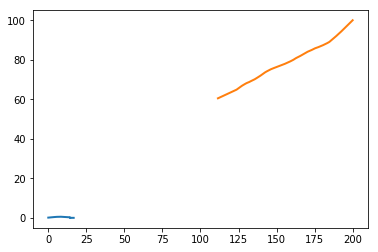

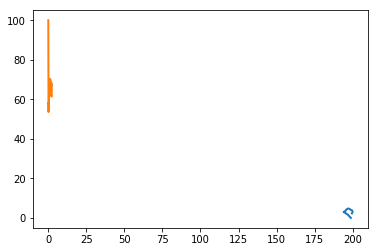

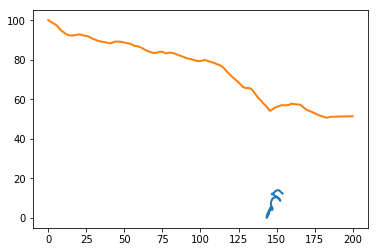

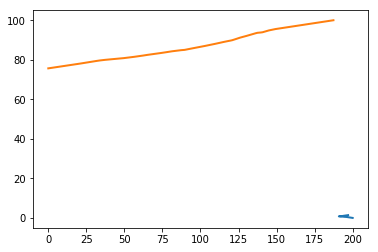

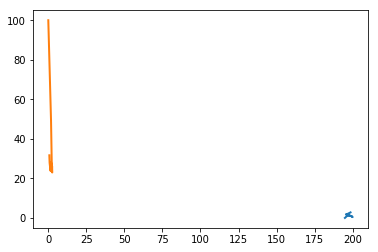

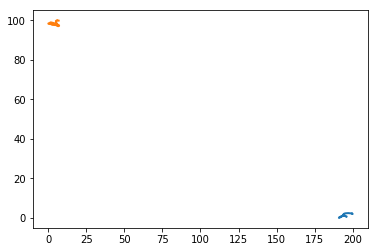

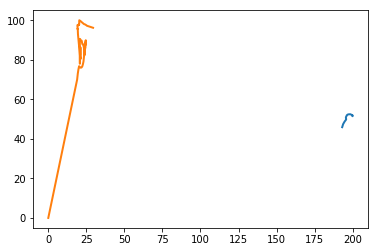

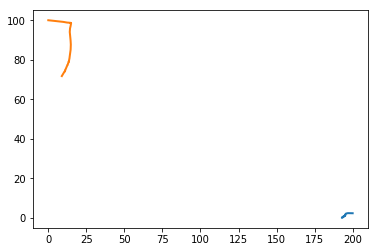

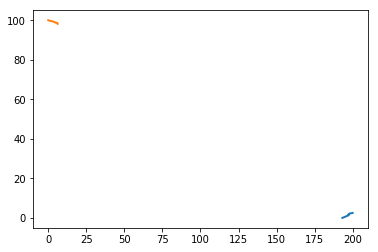

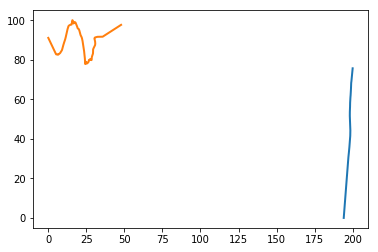

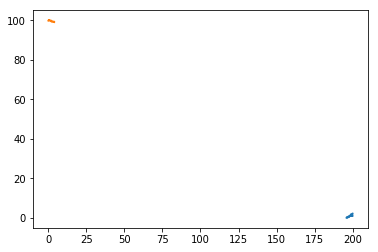

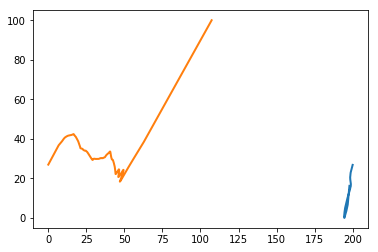

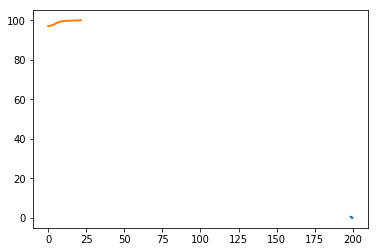

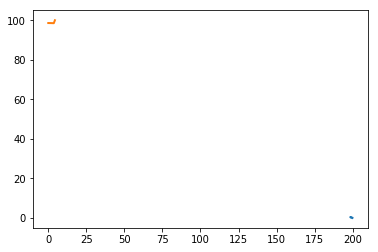

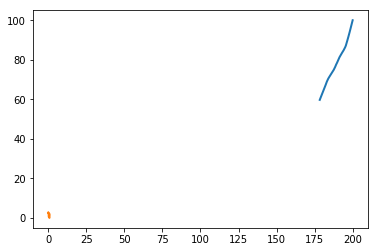

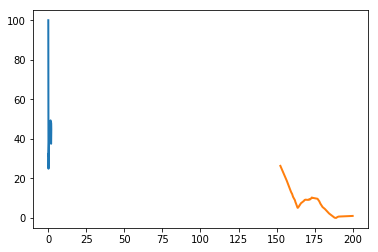

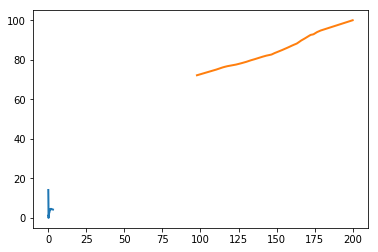

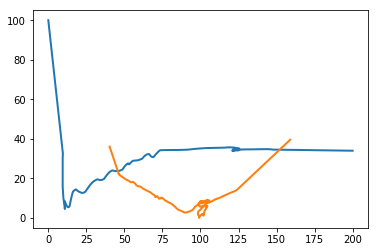

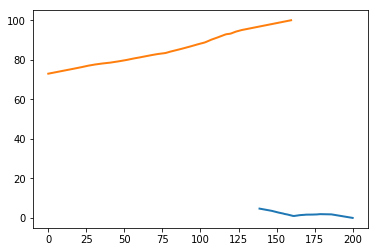

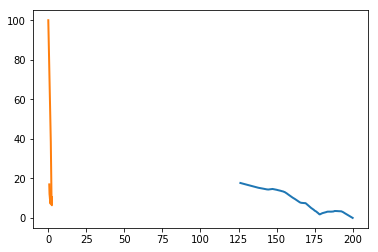

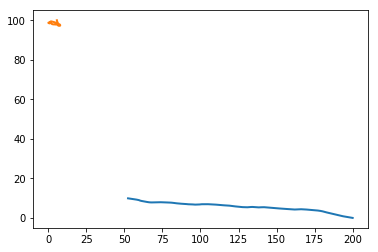

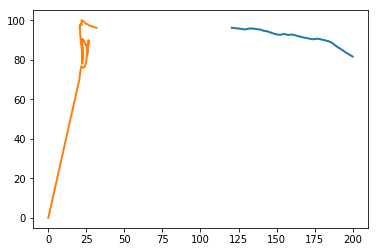

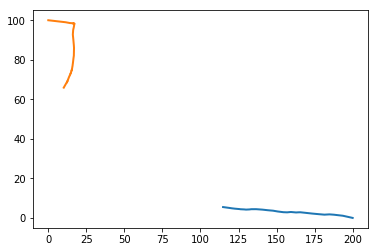

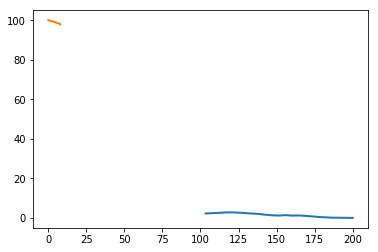

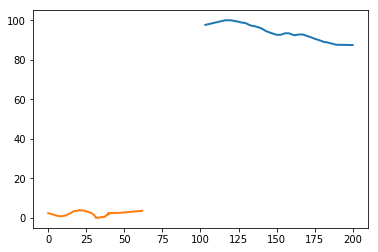

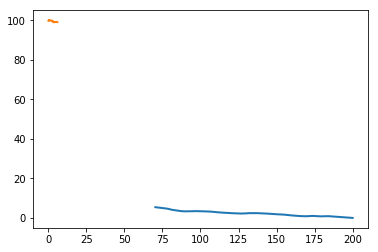

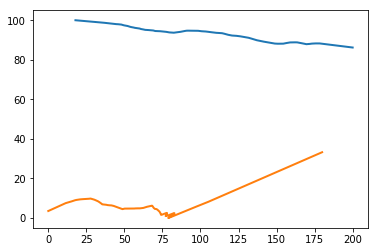

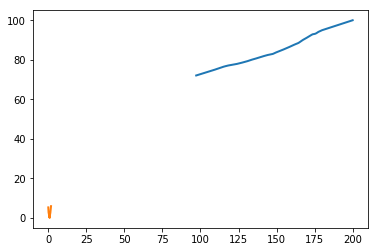

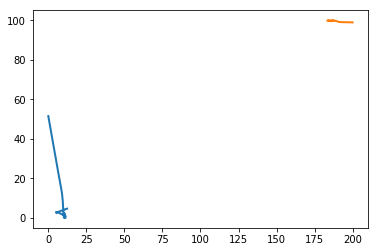

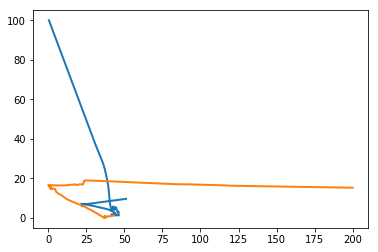

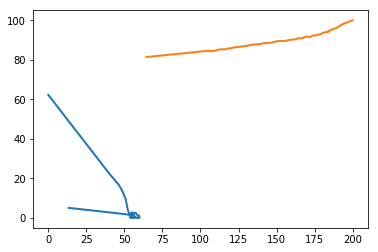

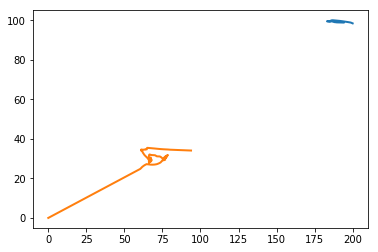

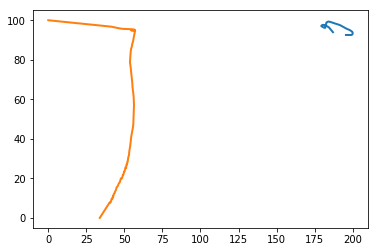

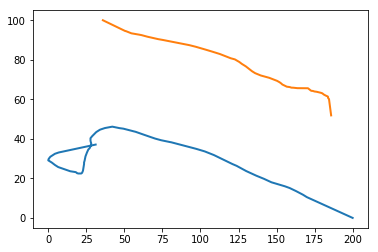

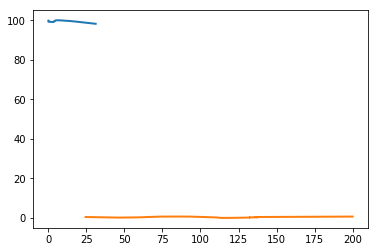

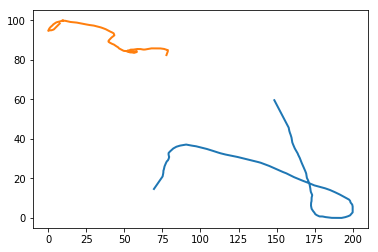

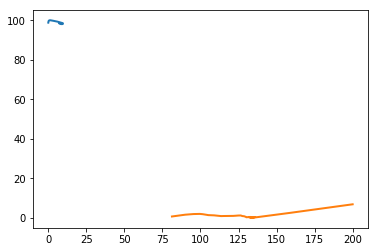

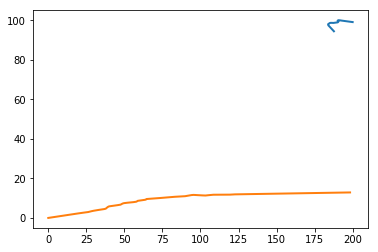

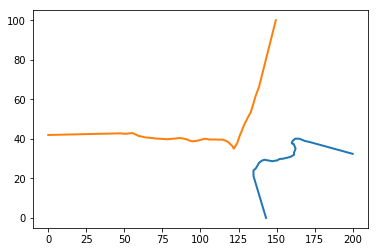

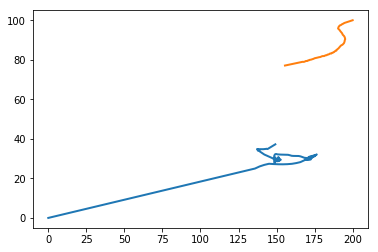

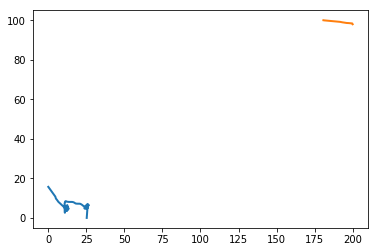

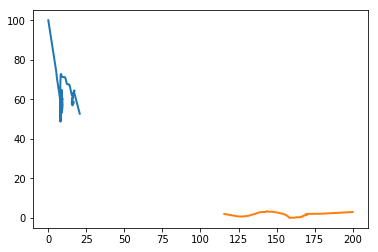

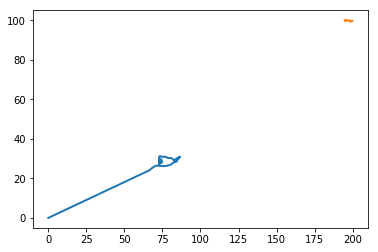

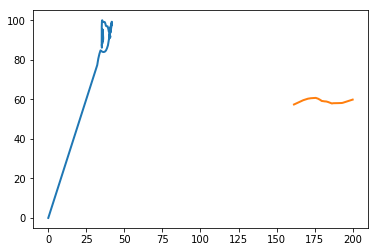

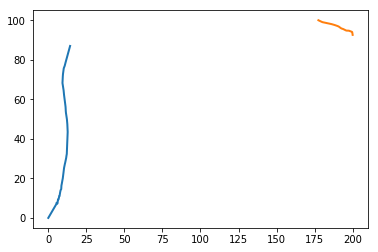

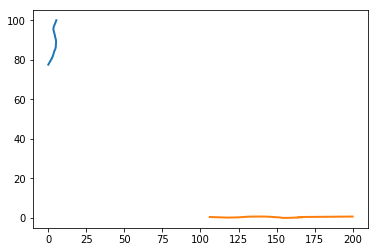

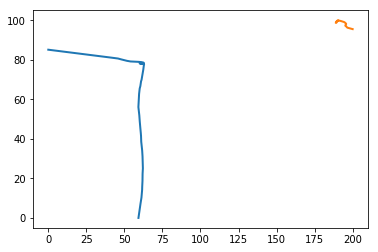

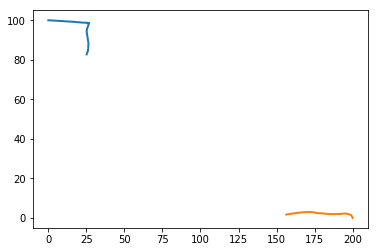

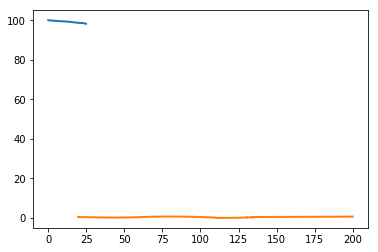

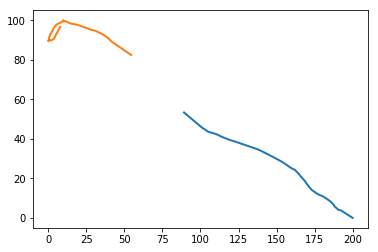

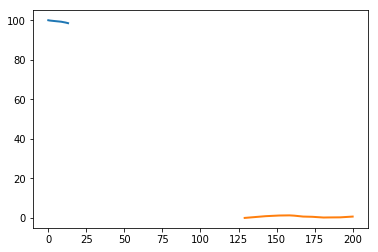

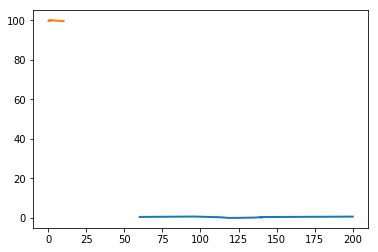

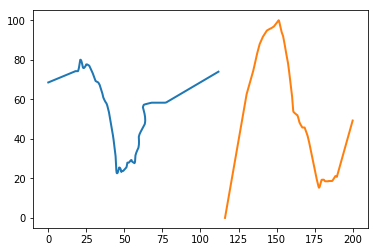

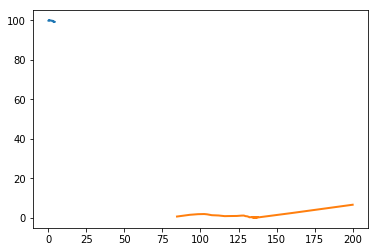

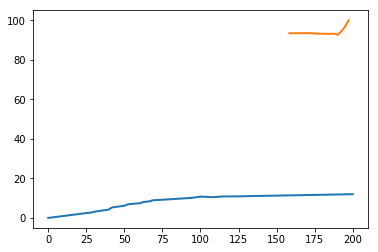

In [339]:
for p in pairs:
    plotPair(p[0],p[1],height,width)

In [348]:
gifDirectory = 'data/gifs/street1/6/'
for k in range(len(pairs)):
    t1,t2 = pairs[k]
    x1 = np.array([x for x,y in t1]).astype(int)
    y1 = np.array([y for x,y in t1]).astype(int)
    x2 = np.array([x for x,y in t2]).astype(int)
    y2 = np.array([y for x,y in t2]).astype(int)
    images = []
    for i in range(len(x1)):
        img = np.zeros((100,200,3), np.uint8)
        cv2.circle(img,(x1[i],y1[i]), 10, (0,0,255), -1)
        cv2.circle(img,(x2[i],y2[i]), 10, (0,255,0), -1)
        for j in range(i):
            cv2.line(img,(x1[j],y1[j]),(x1[j+1],y1[j+1]),(0,0,255),3)
            cv2.line(img,(x2[j],y2[j]),(x2[j+1],y2[j+1]),(0,255,0),3)
        images.append(img)
    fps = int(len(x1)/5)
    imageio.mimsave(gifDirectory+str(k)+'.gif', images, fps=fps)

In [298]:
imageio.mimsave('test12.gif', images, fps=30)
HTML('<img src="test12.gif">')